In [16]:
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from src.utils import get_item
import timm
import torch


In [17]:
args = get_item()

In [18]:
model = timm.create_model(args.network,pretrained=True,num_classes=9)
# model = timm.create_model('resnet18',pretrained=True,num_classes=9)
model.load_state_dict(torch.load("/mnt/data_lab513/dhsang/model/trial_5_none_meta/fold_4.pth"),strict=False)

_IncompatibleKeys(missing_keys=['conv_stem.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'blocks.0.0.conv_dw.weight', 'blocks.0.0.bn1.weight', 'blocks.0.0.bn1.bias', 'blocks.0.0.bn1.running_mean', 'blocks.0.0.bn1.running_var', 'blocks.0.0.se.conv_reduce.weight', 'blocks.0.0.se.conv_reduce.bias', 'blocks.0.0.se.conv_expand.weight', 'blocks.0.0.se.conv_expand.bias', 'blocks.0.0.conv_pw.weight', 'blocks.0.0.bn2.weight', 'blocks.0.0.bn2.bias', 'blocks.0.0.bn2.running_mean', 'blocks.0.0.bn2.running_var', 'blocks.1.0.conv_pw.weight', 'blocks.1.0.bn1.weight', 'blocks.1.0.bn1.bias', 'blocks.1.0.bn1.running_mean', 'blocks.1.0.bn1.running_var', 'blocks.1.0.conv_dw.weight', 'blocks.1.0.bn2.weight', 'blocks.1.0.bn2.bias', 'blocks.1.0.bn2.running_mean', 'blocks.1.0.bn2.running_var', 'blocks.1.0.se.conv_reduce.weight', 'blocks.1.0.se.conv_reduce.bias', 'blocks.1.0.se.conv_expand.weight', 'blocks.1.0.se.conv_expand.bias', 'blocks.1.0.conv_pwl.weight', 'blocks.1.0.bn3.weigh

In [19]:
target_layers = [model.conv_head]

In [20]:
import cv2
import os
import albumentations as A

In [21]:
rgb_img = cv2.imread(os.path.join(args.data_dir,'ISIC_0000000.jpg'))
cv2.imwrite('raw.jpg',rgb_img)

True

In [22]:
import pandas as pd
df = pd.read_csv('./csvfile/full_train.csv')

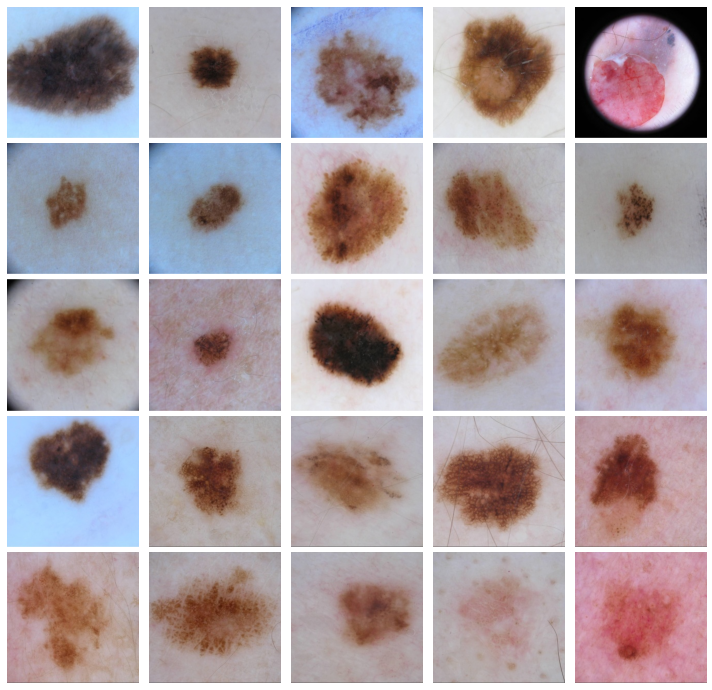

In [23]:
holo = df
import matplotlib.pyplot as plt
import os
f , ax = plt.subplots(5,5)
f.set_size_inches(10, 10)
k = 0
for i in range(5):
    for j in range(5):
        path = os.path.join("/mnt/data_lab513/dhsang/data/256x256",holo.iloc[k][0])
        x = cv2.imread(path)
        x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
        # x = trans(image=x)
        # x = x["image"]
        ax[i,j].axis('off')
        ax[i,j].imshow(x)
        k = k + 1
    plt.tight_layout()

In [24]:
rgb_img = cv2.imread(os.path.join(args.data_dir,'ISIC_0000000.jpg'))[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

In [25]:
targets = None

In [26]:
cam_algorithm = ScoreCAM

In [27]:
with cam_algorithm(model=model,
                    target_layers=target_layers,
                    use_cuda=True) as cam:
    cam.batch_size = 30
    grayscale_cam = cam(input_tensor=input_tensor,
                            targets=targets,
                            aug_smooth=False,
                            eigen_smooth=False)
    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

In [28]:
gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
gb = gb_model(input_tensor, target_category=None)
cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask * gb)
gb = deprocess_image(gb)
cv2.imwrite('GradCAM_cam.jpg', cam_image)

True